<div class="head1">
    <div class="head1__name">
        Check the formula for the matrix rank-1 dot product with interpolated vector
    </div>
</div>

Consider diffusion equation on the $d$-dimensional Chebyshev spatial grid with $n_1, n_2, \ldots, n_d$ points
$$
    \frac{\partial v}{\partial t} = D_c \Delta v,
    \quad
    v = v(x, t) \in R
    \quad
    x \in R^{d},
    \quad
    D_c \in R,
$$
$$
    D_c \Delta =
        D_1 \otimes I_2 \otimes \ldots \otimes I_d +
        I_1 \otimes D_2 \otimes \ldots \otimes I_d +
        \ldots
        I_1 \otimes I_2 \otimes \ldots \otimes D_d,
$$
where $D_k \in R^{n_k \times n_k}$ is the 2th order Chebyshev differential matrix (multiplied by $D_c$) having the same size as the number of points along the corresponding spatial axis $k$.

Let $v \in R^{n_1 \times n_2 \times \ldots \times n_d}$ be the known discrete solution at the moment $t$, when for solution $v_1$ at the moment $t+h$ we have
$$
    vec(v_1) = e^{h D_c \Delta} vec(v),
$$
and due to the special form of the operator, we come to
$$
    vec(v_1) = \left(
        \underbrace{
            e^{h D_1} \otimes e^{h D_2} \otimes \ldots \otimes e^{h D_d}
        }_{d} \right) vec(v).
$$

Suppose that we interpolated $v$ on the Chebyshev grid by Chebyshev polynomials
$$
    v(x_1, \ldots x_d) \approx
        \sum_{i_1=1}^{n_1} \sum_{i_2=1}^{n_2} \ldots \sum_{i_d=1}^{n_d}
            A_{i_1, i_2, \ldots, i_d}
            T_{i_1}(x_1) T_{i_2}(x_2) \ldots T_{i_d}(x_d),
$$
then on the flatten Chebyshev grid the vector of function values may be represented as
$$
    vec(v) \approx
        \sum_{i_1=1}^{n_1} \sum_{i_2=1}^{n_2} \ldots \sum_{i_d=1}^{n_d}
            A_{i_1, i_2, \ldots, i_d}
            T_{i_1}^{(1)} \otimes T_{i_2}^{(2)} \otimes \ldots \otimes T_{i_d}^{(d)},
$$
where $T_{i_k}^{(k)} \in R^{n_k}$ is the vector of the values of Chebyshev polynomial of the $i_k$-th order in the spatial points from $k$-th axis and $A$ is the vectorized tensor of the interpolation coefficients.

The tensor of coefficients is represented in the TT-format
$$
    A_{i_1, i_2, \ldots, i_d} \approx
        G^{(1)}_{:, i_1, :}
        G^{(2)}_{:, i_2, :}
        \ldots
        G^{(d)}_{:, i_d, :},
$$
$$
    vec(A) \approx
        \sum_{r_1=1}^{R_1} \sum_{r_2=1}^{R_2} \ldots \sum_{r_{d-1}=1}^{R_{d-1}}
            G^{(1)}_{1, :, r_1}
            \otimes
            G^{(2)}_{r_1, :, r_2}
            \otimes
            \ldots
            \otimes G^{(d)}_{r_{d-1}, :, 1 },
$$
with TT-cores $G^{(k)} \in R^{R_{k-1} \times n_k \times R_k}$ ($R_0 = R_d = 1$).

Then we have
$$
    v(x_1, \ldots x_d) \approx
        \left( \sum_{i_1=1}^{n_1} G^{(1)}_{:, i_1, :} T_{i_1}(x_1) \right)
        \left( \sum_{i_2=1}^{n_2} G^{(2)}_{:, i_2, :} T_{i_2}(x_2) \right)
        \ldots
        \left( \sum_{i_d=1}^{n_d} G^{(d)}_{:, i_d, :} T_{i_d}(x_d) \right),
$$
$$
    vec(v) \approx
        \sum_{i_1=1}^{n_1} \sum_{i_2=1}^{n_2} \ldots \sum_{i_d=1}^{n_d}
            G^{(1)}_{:, i_1, :} G^{(2)}_{:, i_2, :} \ldots G^{(d)}_{:, i_d, :}
            T_{i_1}^{(1)} \otimes T_{i_2}^{(2)} \otimes \ldots \otimes T_{i_d}^{(d)}.
$$

And then ... (???)

In [1]:
import sys
import time

import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

import tt

sys.path.extend(['./../lib', './../helpers'])
from solver import Solver as Solver
from intertrain import Intertrain
from helpers import init_jupyter

init_jupyter()

Start |  8:11PM MSK on Sep 12, 2019 |
-------------------------------------


In [14]:
d = 3
s_coef = 0.1
D_coef = 0.02
t_min, t_max, t_poi = +0., +1., 1000
x_min, x_max, x_poi = -1., +1., 11

def func_r0(x):
    a = 2. * s_coef
    r = np.exp(-np.sum(x*x, axis=0) / a) / (np.pi * a)**(7/2)
    return r.reshape(-1)

In [15]:
SL = Solver(d=d, eps=1.E-10, with_tt=True)
SL.set_grid_t(t_poi, t_min, t_max)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(None, None, func_r0, None, None)
SL.prep()

X = SL.IT.grid()   # Full spatial grid
IT0 = SL.IT.copy() # Interpolation result for r0

In [16]:
J0 = np.eye(SL.n); J0[0, 0] = 0.; J0[-1, -1] = 0.
Z0 = expm(SL.h/2. * SL.Dc * J0 @ SL.D2)

In [17]:
# Explicit calculation

SL.IT = IT0.copy()

Z = Z0.copy()
for _ in range(1, SL.d): Z = np.kron(Z, Z0)
            
v1 = Z @ SL.IT.calc(X)

In [20]:
# Calculation by the product of TT-cores

SL.IT = IT0.copy()

G = tt.tensor.to_list(SL.IT.A)
        
for i in range(SL.d):
    G[i] = np.einsum('ij,kim->kjm', Z0, G[i])
    
SL.IT.A = tt.tensor.from_list(G).round(SL.eps)

v2 = SL.IT.calc(X)

Error: 9.31e-02


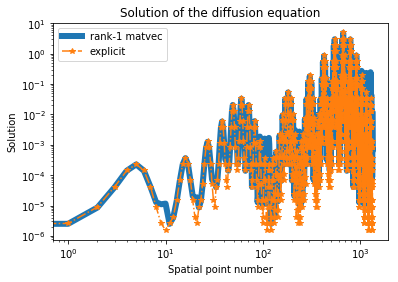

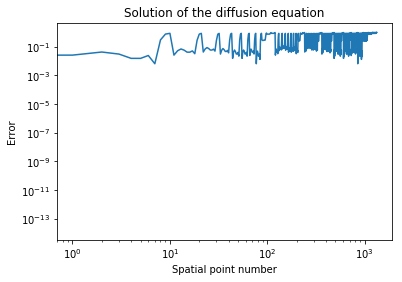

In [21]:
# Check of the result

e = np.linalg.norm(v2 - v1) / np.linalg.norm(v2)
print('Error: %8.2e'%e)

plt.plot(np.arange(X.shape[1]), v2, linewidth=6, label='rank-1 matvec')
plt.plot(np.arange(X.shape[1]), v1, '-.', marker='*', label='explicit')
plt.title('Solution of the diffusion equation')
plt.xlabel('Spatial point number')
plt.ylabel('Solution')
plt.semilogx()
plt.semilogy()
plt.legend(loc='best')
plt.show()

e = np.abs(v2 - v1) / np.abs(v2)
plt.plot(np.arange(X.shape[1]), e)
plt.title('Solution of the diffusion equation')
plt.xlabel('Spatial point number')
plt.ylabel('Error')
plt.semilogx()
plt.semilogy()
plt.show()

<div class="end"></div>